# Julia is Fast - `@time`, `@elapsed` and `@inbounds`

---

In this notebook, we demonstrate how fast `Julia` is, compared to other dynamically typed languages. 

## Prerequisites

Read the text [Why Julia?](https://github.com/stevengj/julia-mit/blob/master/README.md#why-julia) (3 min)

Read [Performance tips](http://julia.readthedocs.org/en/latest/manual/performance-tips/) section of the `Julia` manual. (20 min) 

## Competences 

The reader should understand effects of "[just-in-time
compiler](https://en.wikipedia.org/wiki/Just-in-time_compilation)"
called [LLVM](http://llvm.org/)`LLVM` on the speed of execution of programs. 
The reader should be able to write simple, but fast, programs containing loops.

## Credits 

Some examples are taken from [The Julia Manual](http://julia.readthedocs.org/en/latest/manual/).


## Scholarly example - summing integer halves

Consider the function `f` which sums halves of integers from `1` to `n`:

__N.B.__ `Esc l` toggles the line numbers in the current cell.

In [1]:
function f(n)
    s = 0
    for i = 1:n
        s += i/2
    end
    s
end

f (generic function with 1 method)

In order for the fast execution, the function must first be compiled. Compilation is performed automatically, when the function is invoked for the first time. Therefore, the first call can be done with some trivial choice of parameters.

The timing can be done by two commands, `@time` and `@elapsed`: 

In [2]:
?@time

```
@time
```

A macro to execute an expression, printing the time it took to execute, the number of allocations, and the total number of bytes its execution caused to be allocated, before returning the value of the expression.


In [3]:
?@elapsed

```
@elapsed
```

A macro to evaluate an expression, discarding the resulting value, instead returning the number of seconds it took to execute as a floating-point number.


In [4]:
@time f(1) 

0.5

0.007184 seconds (2.47 k allocations: 127.565 KB)


In [5]:
@elapsed f(1)  # This run is much faster, since the function is already compiled

3.971e-6

Let us now run the big-size computation. Notice the unnaturally high byte allocation and the huge amount of time spent on 
[garbage collection](http://en.wikipedia.org/wiki/Garbage_collection_%28computer_science%29).

In [6]:
@time f(1000000) # Notice the unnaturally high byte  allocation!

2.5000025e11

0.040911 seconds (2.00 M allocations: 30.518 MB, 8.44% gc time)


In [7]:
@elapsed f(1000000) # We shall be using @time from now on

0.042030389

> Since your computer can execute several _Gigaflops_ (floating-point operations per second), this is rather slow. This slowness is due to _type instability_: variable `s` is in the beginning assumed to be of type `Integer`, while at every other step, the result is a real number of type `Float64`. Permanent checking of types requires permanent memory allocation and deallocation (garbage collection). This is corrected by very simple means: just declare `s` as a real number, and the execution is more than 10 times faster with almost no memory allocation (and, consequently, no garbage collection).

In [8]:
function f1(n)
    s = 0.0
    for i = 1:n
        s += i/2
    end
    s
end

f1 (generic function with 1 method)

In [9]:
@time f1(1)

0.5

0.004599 seconds (1.79 k allocations: 90.275 KB)


In [10]:
@time f1(1000000)

2.5000025e11

0.001777 seconds (5 allocations: 176 bytes)


`@time` can alo be invoked as a function, but only on a function call, and not when the output is assigned, as well:

In [11]:
@time(f1(1000000))

2.5000025e11

0.001680 seconds (5 allocations: 176 bytes)


In [12]:
@time s2=f1(1000000)

2.5000025e11

0.001780 seconds (6 allocations: 224 bytes)


In [13]:
@time(s2=f1(1000000))

LoadError: LoadError: unsupported or misplaced expression kw
while loading In[13], in expression starting on line 155

## Real-world example - exponential moving average

[Exponential moving average](http://en.wikipedia.org/wiki/Moving_average#Exponential_moving_average) is a fast _one pass_ formula (each data point of the given data set $A$ is accessed only once) often used in high-frequency on-line trading (see [Online Algorithms in High-Frequency Trading](http://cacm.acm.org/magazines/2013/10/168184-online-algorithms-in-high-frequency-trading/fulltext) for more details). __Notice that the output array $X$ is declared in advance.__

Using `return` in the last line is here optional.


In [14]:
function fexpma{T}( A::Vector{T}, alpha::T )
# fast exponential moving average: X - moving average, A - data, alpha - exponential forgetting parameter
    n = length(A)
    X = Array(T,n) # Declare X
    beta = one(T)-alpha
    X[1] = A[1]
    for k = 2:n
        X[k] = beta*A[k] + alpha*X[k-1]
    end
    return X
end


fexpma (generic function with 1 method)

In [15]:
fexpma([1.0],0.5) # First run for compilation

1-element Array{Float64,1}:
 1.0

We now generate some big-size data:

In [16]:
A=[rand() + 0.00001*k*rand() for k=1:20_000_000] # Big random sequence with slightly growing tendency

20000000-element Array{Float64,1}:
   0.730839
   0.662931
   0.544842
   0.717339
   0.190454
   0.305703
   0.959483
   0.637811
   0.113677
   0.412956
   0.237584
   0.566539
   0.976854
   ⋮       
  83.5179  
  27.2391  
 131.377   
 181.824   
  33.6962  
 139.54    
  32.8518  
 103.543   
  34.7559  
  30.7029  
  96.9134  
  65.4199  

In [17]:
@time X=fexpma(A,0.9)

20000000-element Array{Float64,1}:
  0.730839
  0.724048
  0.706128
  0.707249
  0.655569
  0.620583
  0.654473
  0.652806
  0.598893
  0.5803  
  0.546028
  0.548079
  0.590957
  ⋮       
 63.7863  
 60.1316  
 67.2561  
 78.7129  
 74.2113  
 80.7442  
 75.9549  
 78.7137  
 74.3179  
 69.9564  
 72.6521  
 71.9289  

0.192595 seconds (7 allocations: 152.588 MB, 1.18% gc time)


## `@inbounds`

The `@inbounds` command eliminates array bounds checking within expressions. Be certain before doing this. If the subscripts are ever out of bounds, you may suffer crashes or silent corruption. The above program runs 40% faster.,

In [18]:
function fexpma{T}( A::Vector{T}, alpha::T )
# fast exponential moving average: X - moving average, A - data, alpha - exponential forgetting parameter
    n = length(A)
    X = Array(T,n) # Declare X
    beta = one(T)-alpha
    X[1] = A[1]
    @inbounds for k = 2:n
        X[k] = beta*A[k] + alpha*X[k-1]
    end
    return X
end

fexpma (generic function with 1 method)

In [20]:
@time X=fexpma(A,0.9)

20000000-element Array{Float64,1}:
  0.730839
  0.724048
  0.706128
  0.707249
  0.655569
  0.620583
  0.654473
  0.652806
  0.598893
  0.5803  
  0.546028
  0.548079
  0.590957
  ⋮       
 63.7863  
 60.1316  
 67.2561  
 78.7129  
 74.2113  
 80.7442  
 75.9549  
 78.7137  
 74.3179  
 69.9564  
 72.6521  
 71.9289  

0.178561 seconds (6 allocations: 152.588 MB, 16.47% gc time)


Similar `Matlab` programs give the following timing for the two versions of the function, first _without_ prior declaration of $X$ and then _with_ prior declaration. The _latter_ version is several times faster, but still slow. 

---
```
function X = fexpma0( A,alpha )
% fast exponential moving average: X - moving average, A - data, alpha - exponential forgetting parameter
n=length(A);
beta=1-alpha;
X(1)=A(1);
for k=2:n
    X(k)=beta*A(k)+alpha*X(k-1);
end
```
```
>> A=rand(20000000,1)+0.00001*[1:20000000]'.*rand(20000000,1);
>> tic, X=fexpma0(A,0.9); toc
Elapsed time is 3.073359 seconds.
```

---

```
function X = fexpma( A,alpha )
% fast exponential moving average: X - moving average, A - data, alpha - exponential forgetting parameter
n=length(A);
X=zeros(n,1); % Allocate X in advance
beta=1-alpha;
X(1)=A(1);
for k=2:n
    X(k)=beta*A(k)+alpha*X(k-1);
end
```
```
>> tic, X=fexpma(A,0.9); toc
Elapsed time is 0.320976 seconds.
```

## Plotting the moving average

Let us plot the data $A$ and its exponential moving average $X$. The dimension of the data is too large for meaningful direct plot. In `Julia` we can use `@manipulate` command to slide through the data. It takes a while to read packages `Winston` (for plotting) and `Interact`, but this is needed only for the first invocation.

In [22]:
using Winston
using Interact

Interact.Slider{Int64}(Signal{Int64}(9999001, nactions=0),"k",9999001,1:1000:19999001,true)

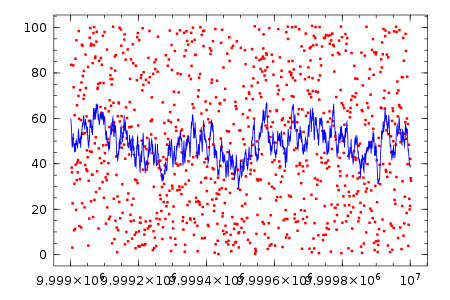

In [23]:
@manipulate for k=1:1000:20000000
    plot(collect(k:k+1000),A[k:k+1000],"r.",collect(k:k+1000),X[k:k+1000],"b")
end

### Remark
More details about optimizing your programs are given in the [Profiling Notebook]().

## Pre-allocating output

The following example is from [Pre-allocating outputs](http://julia.readthedocs.org/en/latest/manual/performance-tips/#pre-allocating-outputs). The functions `loopinc()` and `loopinc_prealloc()` both compute $\sum_{i=2}^{10000001}i$, the second one being 10 times faster: 

In [29]:
function xinc(x)
    return [x, x+1, x+2]
end

function loopinc()
    y = 0
    for i = 1:10^7
        ret = xinc(i)
        y += ret[2]
    end
    y
end

function xinc!{T}(ret::AbstractVector{T}, x::T)
    ret[1] = x
    ret[2] = x+1
    ret[3] = x+2
    nothing
end

function loopinc_prealloc()
    ret = Array(Int, 3)
    y = 0
    for i = 1:10^7
        xinc!(ret, i)
        y += ret[2]
    end
    y
end

loopinc_prealloc (generic function with 1 method)

In [31]:
@time loopinc()

50000015000000

0.675429 seconds (40.00 M allocations: 1.341 GB, 25.75% gc time)


In [33]:
@time loopinc_prealloc() # After the second run

50000015000000

0.051934 seconds (6 allocations: 272 bytes)


## Memory access

The following example is from [Access arrays in memory order, along columns](http://julia.readthedocs.org/en/latest/manual/performance-tips/#access-arrays-in-memory-order-along-columns).

Multidimensional arrays in Julia are stored in column-major order, which means that arrays are stacked one column at a time. This convention for ordering arrays is common in many languages like Fortran, Matlab, and R (to name a few). The alternative to column-major ordering is row-major ordering, which is the convention adopted by C and Python (numpy) among other languages. The ordering can be verified using the `vec()` function or the syntax `[:]`:

In [34]:
B = rand(0:9,4,3)

4x3 Array{Int64,2}:
 6  3  1
 5  8  2
 4  4  6
 0  7  0

In [35]:
B[:]

12-element Array{Int64,1}:
 6
 5
 4
 0
 3
 8
 4
 7
 1
 2
 6
 0

In [36]:
vec(B)

12-element Array{Int64,1}:
 6
 5
 4
 0
 3
 8
 4
 7
 1
 2
 6
 0

The ordering of arrays can have significant performance effects when looping over arrays. Loops should be organized such that the subsequent accessed elements are close to each other in physical memory.

The following functions accept a `Vector` and and return a square `Array` with the rows or the columns filled with copies of the input vector, respectively.

In [37]:
function copy_cols{T}(x::Vector{T})
    n = size(x, 1)
    out = Array(eltype(x), n, n)
    for i=1:n
        out[:, i] = x
    end
    out
end

function copy_rows{T}(x::Vector{T})
    n = size(x, 1)
    out = Array(eltype(x), n, n)
    for i=1:n
        out[i, :] = x
    end
    out
end

copy_rows (generic function with 1 method)

In [39]:
copy_cols([1.0,2])
copy_rows([1.0,2])

2x2 Array{Float64,2}:
 1.0  2.0
 1.0  2.0

In [40]:
x=rand(5000) # generate a random vector

5000-element Array{Float64,1}:
 0.584088 
 0.123995 
 0.706473 
 0.277878 
 0.812163 
 0.807963 
 0.0946712
 0.93232  
 0.656777 
 0.520534 
 0.405492 
 0.385659 
 0.997815 
 ⋮        
 0.289552 
 0.540741 
 0.207564 
 0.0756819
 0.20071  
 0.0562943
 0.909588 
 0.506497 
 0.0210987
 0.407645 
 0.88234  
 0.1267   

In [46]:
@time C=copy_cols(x)  # We generate a large matrix

5000x5000 Array{Float64,2}:
 0.584088   0.584088   0.584088   …  0.584088   0.584088   0.584088 
 0.123995   0.123995   0.123995      0.123995   0.123995   0.123995 
 0.706473   0.706473   0.706473      0.706473   0.706473   0.706473 
 0.277878   0.277878   0.277878      0.277878   0.277878   0.277878 
 0.812163   0.812163   0.812163      0.812163   0.812163   0.812163 
 0.807963   0.807963   0.807963   …  0.807963   0.807963   0.807963 
 0.0946712  0.0946712  0.0946712     0.0946712  0.0946712  0.0946712
 0.93232    0.93232    0.93232       0.93232    0.93232    0.93232  
 0.656777   0.656777   0.656777      0.656777   0.656777   0.656777 
 0.520534   0.520534   0.520534      0.520534   0.520534   0.520534 
 0.405492   0.405492   0.405492   …  0.405492   0.405492   0.405492 
 0.385659   0.385659   0.385659      0.385659   0.385659   0.385659 
 0.997815   0.997815   0.997815      0.997815   0.997815   0.997815 
 ⋮                                ⋱                                 
 0.289

0.124434 seconds (4.50 k allocations: 190.804 MB)


In [47]:
@time D=copy_rows(x) # This is several times slower

5000x5000 Array{Float64,2}:
 0.584088  0.123995  0.706473  0.277878  …  0.407645  0.88234  0.1267
 0.584088  0.123995  0.706473  0.277878     0.407645  0.88234  0.1267
 0.584088  0.123995  0.706473  0.277878     0.407645  0.88234  0.1267
 0.584088  0.123995  0.706473  0.277878     0.407645  0.88234  0.1267
 0.584088  0.123995  0.706473  0.277878     0.407645  0.88234  0.1267
 0.584088  0.123995  0.706473  0.277878  …  0.407645  0.88234  0.1267
 0.584088  0.123995  0.706473  0.277878     0.407645  0.88234  0.1267
 0.584088  0.123995  0.706473  0.277878     0.407645  0.88234  0.1267
 0.584088  0.123995  0.706473  0.277878     0.407645  0.88234  0.1267
 0.584088  0.123995  0.706473  0.277878     0.407645  0.88234  0.1267
 0.584088  0.123995  0.706473  0.277878  …  0.407645  0.88234  0.1267
 0.584088  0.123995  0.706473  0.277878     0.407645  0.88234  0.1267
 0.584088  0.123995  0.706473  0.277878     0.407645  0.88234  0.1267
 ⋮                                       ⋱                    

0.415047 seconds (4.50 k allocations: 190.804 MB, 12.76% gc time)


### Remark
There is also a built-in function `repmat()`:

In [48]:
?repmat

search: 

```
repmat(A, n, m)
```

Construct a matrix by repeating the given matrix `n` times in dimension 1 and `m` times in dimension 2.


repmat



In [49]:
@time C1=repmat(x,1,5000)

5000x5000 Array{Float64,2}:
 0.584088   0.584088   0.584088   …  0.584088   0.584088   0.584088 
 0.123995   0.123995   0.123995      0.123995   0.123995   0.123995 
 0.706473   0.706473   0.706473      0.706473   0.706473   0.706473 
 0.277878   0.277878   0.277878      0.277878   0.277878   0.277878 
 0.812163   0.812163   0.812163      0.812163   0.812163   0.812163 
 0.807963   0.807963   0.807963   …  0.807963   0.807963   0.807963 
 0.0946712  0.0946712  0.0946712     0.0946712  0.0946712  0.0946712
 0.93232    0.93232    0.93232       0.93232    0.93232    0.93232  
 0.656777   0.656777   0.656777      0.656777   0.656777   0.656777 
 0.520534   0.520534   0.520534      0.520534   0.520534   0.520534 
 0.405492   0.405492   0.405492   …  0.405492   0.405492   0.405492 
 0.385659   0.385659   0.385659      0.385659   0.385659   0.385659 
 0.997815   0.997815   0.997815      0.997815   0.997815   0.997815 
 ⋮                                ⋱                                 
 0.289

0.167700 seconds (60.16 k allocations: 193.389 MB)
